
Hi I'm 陳羽楨, B094020019.

2. Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as Func
import numpy as np
import random


def rotate_img(img, rot):
    if rot == 0: # 0 degrees rotation
        return img
    #######################################################################
    #        TODO: Implement rotate_img() - return the rotated img        #                           
    #######################################################################
    elif rot == 1: # 90 degrees 
        return Func.rotate(img, 90)
    elif rot == 2: # 180 degrees 
        return Func.rotate(img, 180)
    elif rot == 3: # 270 degrees 
        return Func.rotate(img, 270)
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')

    #######################################################################
    #                           End of your code                          #
    #######################################################################

class CIFAR10Rotation(torchvision.datasets.CIFAR10):    
    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [8]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


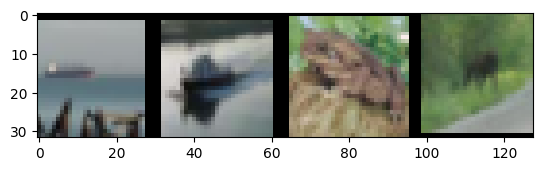

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class labels:  ship  ship  frog  deer 


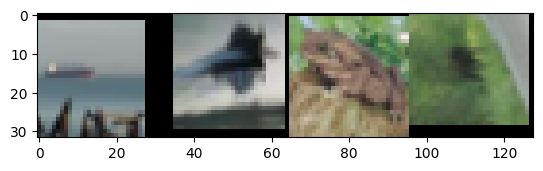

Rotation labels:  0     180   0     90   


In [9]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    img = transforms.Normalize((0, 0, 0), (1/0.2023, 1/0.1994, 1/0.2010))(img)
    img = transforms.Normalize((-0.4914, -0.4822, -0.4465), (1, 1, 1))(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

In [10]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0) #總共幾類
            correct += (predicted == labels).sum().item() #對的有幾個
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [11]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet34

net = resnet34(weights = None, num_classes=4) # Do not modify this line.
# conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1, groups=1)
# net.Conv2d_1a_3x3.conv = conv1

net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

In [15]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #  
            # TODO: Zero the parameter gradients                                                                 #
            # TODO: forward + backward + optimize                                                                #
            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            if task == 'rotation':
              images, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
              images, labels = imgs.to(device), cls_label.to(device)
            
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs, 1)
            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################                                            


            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        net.eval()
        run_test(net, testloader, criterion, task) 
        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################  

    print('Finished Training')
    
    try:
        if trainloader:
            trainloader.shutdown()
        if testloader:
            testloader.shutdown()
    except Exception as e:
        pass

In [224]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
################################
#     TODO: Save the model     #  
################################
torch.save(net.state_dict(), 'A4-else-1save.pt')
################################
#      End of your code        #  
################################

[1,   100] loss: 0.483 acc: 81.56 time: 2.95
[1,   200] loss: 0.504 acc: 80.23 time: 2.86
[1,   300] loss: 0.503 acc: 80.68 time: 2.78
TESTING:
Accuracy of the network on the 10000 test images: 80.32 %
Average loss on the 10000 test images: 0.525
[2,   100] loss: 0.499 acc: 81.25 time: 2.93
[2,   200] loss: 0.504 acc: 80.73 time: 2.82
[2,   300] loss: 0.506 acc: 80.69 time: 2.77
TESTING:
Accuracy of the network on the 10000 test images: 78.71 %
Average loss on the 10000 test images: 0.540
[3,   100] loss: 0.501 acc: 80.80 time: 2.89
[3,   200] loss: 0.508 acc: 80.20 time: 2.80
[3,   300] loss: 0.509 acc: 80.74 time: 2.74
TESTING:
Accuracy of the network on the 10000 test images: 80.62 %
Average loss on the 10000 test images: 0.507
[4,   100] loss: 0.500 acc: 80.74 time: 2.92
[4,   200] loss: 0.494 acc: 81.13 time: 2.77
[4,   300] loss: 0.499 acc: 80.69 time: 2.84
TESTING:
Accuracy of the network on the 10000 test images: 80.27 %
Average loss on the 10000 test images: 0.502
[5,   100] l

## Fine-tuning on the pre-trained model

In [16]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################
net.load_state_dict(torch.load('A4-else-1save.pt'))
net.fc = nn.Linear(512,10)
print(net) # print your model and check the num_classes is correct
####################################################
#                End of your code                  #   
####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
from torch import nn
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     #
#################################################################################################
for name, child in net.named_children():
    if name not in ['layer4', 'fc']:
        for param in child.parameters():
            param.requires_grad = False
    else:
        for param in child.parameters():
            param.requires_grad = True

net = net.to(device)
#################################################################################################
#                                          End of your code                                     #
#################################################################################################

In [18]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 layer4.2.conv1.weight
	 layer4.2.bn1.weight
	 layer4.2.bn1.bias
	 layer4.2.conv2.weight
	 layer4.2.bn2.weight
	 layer4.2.bn2.bias
	 fc.weight
	 fc.bias


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [20]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

torch.save(net.state_dict(), 'A4-else-2save.pt')

[1,   100] loss: 2.137 acc: 19.29 time: 2.66
[1,   200] loss: 1.816 acc: 30.81 time: 2.37
[1,   300] loss: 1.673 acc: 36.13 time: 2.37
TESTING:
Accuracy of the network on the 10000 test images: 41.76 %
Average loss on the 10000 test images: 1.584
[2,   100] loss: 1.562 acc: 40.93 time: 2.43
[2,   200] loss: 1.530 acc: 42.02 time: 2.35
[2,   300] loss: 1.511 acc: 43.37 time: 2.34
TESTING:
Accuracy of the network on the 10000 test images: 45.94 %
Average loss on the 10000 test images: 1.618
[3,   100] loss: 1.464 acc: 45.64 time: 2.44
[3,   200] loss: 1.461 acc: 45.61 time: 2.39
[3,   300] loss: 1.445 acc: 46.34 time: 2.41
TESTING:
Accuracy of the network on the 10000 test images: 46.40 %
Average loss on the 10000 test images: 1.801
[4,   100] loss: 1.414 acc: 47.77 time: 2.72
[4,   200] loss: 1.417 acc: 47.66 time: 2.37
[4,   300] loss: 1.417 acc: 48.18 time: 2.39
TESTING:
Accuracy of the network on the 10000 test images: 49.78 %
Average loss on the 10000 test images: 1.497
[5,   100] l

## Supervised training on the pre-trained model

In [21]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #  
#####################################################
# net.load_state_dict(torch.load('A4-1save.pt'))
pretrained_dict = torch.load('A4-else-1save.pt')  
net_dict = net.state_dict()

pretrained_dict = {k: v for k, v in pretrained_dict.items() if not k.startswith('fc.')}  


net_dict.update(pretrained_dict) 
net.load_state_dict(net_dict)

net.load_state_dict(torch.load('A4-else-2save.pt'), strict=False)


print(net) # print your model and check the num_classes is correct
#####################################################
#                End of your code                   #   

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [36]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 0.372 acc: 87.28 time: 2.65
[1,   200] loss: 0.392 acc: 86.68 time: 2.49
[1,   300] loss: 0.380 acc: 87.01 time: 2.45
TESTING:
Accuracy of the network on the 10000 test images: 83.34 %
Average loss on the 10000 test images: 0.506
[2,   100] loss: 0.426 acc: 85.40 time: 2.76
[2,   200] loss: 0.367 acc: 87.21 time: 3.39
[2,   300] loss: 0.368 acc: 87.22 time: 2.94
TESTING:
Accuracy of the network on the 10000 test images: 82.83 %
Average loss on the 10000 test images: 0.528
[3,   100] loss: 0.358 acc: 87.78 time: 3.09
[3,   200] loss: 0.358 acc: 87.53 time: 2.95
[3,   300] loss: 0.359 acc: 87.47 time: 3.02
TESTING:
Accuracy of the network on the 10000 test images: 82.22 %
Average loss on the 10000 test images: 0.544
[4,   100] loss: 0.344 acc: 88.29 time: 3.14
[4,   200] loss: 0.332 acc: 88.62 time: 2.94
[4,   300] loss: 0.355 acc: 88.12 time: 2.94
TESTING:
Accuracy of the network on the 10000 test images: 83.28 %
Average loss on the 10000 test images: 0.530
[5,   100] l